In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    savefig
)
from rl_analysis.models_rl.util import zscore_missing_data, shuffle_rows_copy
from rl_analysis.util import count_transitions
from rl_analysis.io.df import dlight_exclude
from functools import partial
from copy import deepcopy
from sklearn import model_selection

import pandas as pd
import numpy as np
import os
import seaborn as sns

In [3]:
# use the numpyro helpers to set the device count
import numpyro
import multiprocessing as mp

numpyro.set_host_device_count(mp.cpu_count() * 10)
numpyro.set_platform("cpu")

import jax
import jax.numpy as jnp
from jax.experimental.maps import Mesh, xmap

In [4]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [5]:
raw_dirs = analysis_config["raw_data"]
dlight_cfg = analysis_config["dlight_common"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
encoding_cfg = analysis_config["dlight_encoding_features"]
figure_cfg = analysis_config["figures"]

In [6]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(
    raw_dirs["dlight"], f"dlight-chrimson_snippets_{file_suffix}.parquet"
)

In [7]:
def sim_body_reward(carry, step, alpha=0.2, gamma=0.2, temperature=10.0, eps=1e-7):
    ll, q_table = carry
    choice, next_choice, reward = step
    choice = jnp.int16(choice)
    next_choice = jnp.int16(next_choice)
    p_vec = (q_table[choice] - jnp.nanmax(q_table[choice])) / temperature

    # set self transition to lowest value - eps
    # use min val
    p_vec = jnp.exp(p_vec)
    ps = p_vec / jnp.nansum(p_vec)
    ps = jnp.nan_to_num(ps, nan=0)

    q_value_predict = q_table[choice, next_choice]
    q_value_real = reward + gamma * jnp.nanmax(q_table[next_choice])
    q_table = q_table.at[choice, next_choice].add(
        alpha * (q_value_real - q_value_predict)
    )

    cur_ll = jnp.log(ps[next_choice] + eps)
    return (ll + cur_ll, q_table), cur_ll


# standard model with no dynamic component
def sim_body_rpe(carry, step, alpha=0.2, gamma=0.2, temperature=10.0, eps=1e-7):
    ll, q_table = carry
    choice, next_choice, reward = step
    choice = jnp.int16(choice)
    next_choice = jnp.int16(next_choice)

    # stable softmax
    p_vec = (q_table[choice] - jnp.nanmax(q_table[choice])) / temperature

    # set self transition to lowest value - eps
    # use min val
    p_vec = jnp.exp(p_vec)
    ps = p_vec / jnp.nansum(p_vec)
    ps = jnp.nan_to_num(ps, nan=0)

    q_table = q_table.at[choice, next_choice].add(alpha * reward)
    cur_ll = jnp.log(ps[next_choice] + eps)
    return (ll + cur_ll, q_table), cur_ll


# simulation wrapper
@jax.jit
def simulate_rpe(
    params,
    q_table,
    sequence,
):
    _sim_body = partial(sim_body_rpe, **params)
    (ll, q_table), cur_ll = jax.lax.scan(_sim_body, (0, q_table), sequence)
    return ll, cur_ll, q_table


# simulation wrapper
@jax.jit
def simulate_reward(params, q_table, sequence):
    _sim_body = partial(sim_body_reward, **params)
    (ll, q_table), cur_ll = jax.lax.scan(_sim_body, (0, q_table), sequence)
    return ll, cur_ll, q_table

## Pre-process data

### Split into train/test by session

In [8]:
use_data = pd.read_parquet(
    os.path.join(raw_dirs["rl_modeling"], "rl_modeling_dlight_data_offline.parquet")
)
use_data = dlight_exclude(
    use_data, exclude_3s=False, exclude_target=False, **dlight_cfg
)
use_data = use_data[~use_data["session_number"].isin([1, 2, 3, 4])].copy()
use_data = use_data.loc[use_data["area"] == "dls"].copy()
use_data = use_data.dropna(subset=["signal_reref_dff_z_max"])

In [9]:
syllable_key = "syllable"
feature_key = "signal_reref_dff_z_max"

In [10]:
cutoff_uuid = 2500
cutoff_date = cutoff_uuid
test_size = 0.5
truncate = 10

In [11]:
group_obj = use_data.groupby(["mouse_id", "uuid"])
use_data = group_obj.filter(lambda x: len(x) >= cutoff_uuid)
group_obj = use_data.groupby(["mouse_id", "uuid"])

In [12]:
# gather data, split off training data for optimizing hyperparameters
seqs = np.array([df[syllable_key].values[:cutoff_date] for k, df in group_obj])
features = np.array([df[feature_key].values[:cutoff_date] for k, df in group_obj])
timestamps = np.array([df["timestamp"].values[:cutoff_date] for k, df in group_obj])
keys = [k for k, _ in group_obj]

In [13]:
nsyllables = use_data["syllable"].max()

In [14]:
base_q_table = np.ones((nsyllables, nsyllables))
np.fill_diagonal(base_q_table, 0)

In [15]:
ref_tms = [count_transitions(_, K=57).astype("float") for _ in seqs]
[np.fill_diagonal(_, np.nan) for _ in ref_tms]
ref_tms = np.array(ref_tms)[:, :truncate, :truncate]

In [16]:
ref_tms_clip = [count_transitions(_[:], K=57).astype("float") for _ in seqs]
[np.fill_diagonal(_, np.nan) for _ in ref_tms_clip]
ref_tms_clip = np.array(ref_tms)[:, :truncate, :truncate]

In [17]:
splits = model_selection.KFold(n_splits=2, shuffle=False)
splits = list(splits.split(range(len(seqs))))
n_splits = len(splits)

In [18]:
train_ref_tms = {}
test_ref_tms = {}
for i, _split in enumerate(splits):
    train_ref_tms[i] = np.nan_to_num(zscore_missing_data(ref_tms_clip[_split[0]], axis=-1), 0).mean(
        axis=0
    )
    test_ref_tms[i] = np.nan_to_num(zscore_missing_data(ref_tms_clip[_split[1]], axis=-1), 0).mean(
        axis=0
    )

In [19]:
mask_threshold = 0  # note results were acceptable with 1 testing with 0

In [20]:
training_nan_mask = np.ones((truncate, truncate), dtype="float")
training_nan_mask[ref_tms.mean(axis=0) <= mask_threshold] = np.nan
np.fill_diagonal(training_nan_mask, np.nan)

In [21]:
z_features = features - features.mean(axis=1, keepdims=True)
z_features /= z_features.std(axis=1, keepdims=True)

# Compare reward v rpe over a large parameter scan

In [22]:
best_lag = 1

In [23]:
parameter_dct = {
    "alpha": np.around(np.arange(0.1, 0.96, 0.2), 2),
    "gamma": np.around(np.arange(0.1, 0.96, 0.2), 2),
    "temperature": [1.0, 10.0],
}

In [24]:
in_axes = [
    [...],
    ["dataset", ...],
    ["dataset", ...],
]

In [25]:
lag_func = lambda x: np.roll(x, best_lag, axis=1)

In [26]:
loss_xmap_reward = xmap(
    simulate_reward,
    in_axes=in_axes,
    out_axes=["dataset", ...],
    axis_resources={"dataset": "x"},
)

loss_xmap_rpe = xmap(
    simulate_rpe,
    in_axes=in_axes,
    out_axes=["dataset", ...],
    axis_resources={"dataset": "x"},
)

In [27]:
sim_funcs = {"reward": loss_xmap_reward, "rpe": loss_xmap_rpe}

In [28]:
param_grid = model_selection.ParameterGrid(parameter_dct)

In [29]:
np.fill_diagonal(base_q_table, np.nan)

In [30]:
rand_input_data = {}

In [31]:
nrands = 10
pool_size = np.round(len(seqs) * 0.75).astype("int")
repeats = 50

In [32]:
for i in tqdm(range(nrands)):
    # NOTE there's no seed here so will get slightly different results each time
    features_rand = shuffle_rows_copy(z_features.copy())  # switched from features 8/23/2022
    rand_input_data[i] = np.stack(
        [seqs[:, :-1], seqs[:, 1:], lag_func(features_rand[:, :-1])], axis=2
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
for use_devices in range(len(jax.devices()), 0, -1):
    if pool_size % use_devices == 0:
        break

In [34]:
dcts = []
input_data = np.stack(
    [seqs[:, :-1], seqs[:, 1:], lag_func(z_features[:, :-1])], axis=2
)

for k, v in tqdm(sim_funcs.items()):
    for dct in tqdm(param_grid):
        rng = np.random.default_rng(0)
        use_dct = deepcopy(dct)
        with Mesh(np.array(jax.devices()[:use_devices]), ("x",)):
            for _repeat in range(repeats):
                use_sessions = rng.choice(range(len(input_data)), size=pool_size)
                q_table = np.array([base_q_table] * pool_size)
                loss, lls, q_table = v(use_dct, q_table, input_data[use_sessions])

                rand_losses = []
                for _rand in range(nrands):
                    q_table = np.array([base_q_table] * pool_size)
                    rand_loss, rand_lls, q_table = v(
                        use_dct, q_table, rand_input_data[_rand][use_sessions]
                    )
                    rand_losses.append(rand_loss.mean())

                rand_mu = np.mean(rand_losses)
                rand_sig = np.std(rand_losses)

                store_dct = deepcopy(dct)
                store_dct["raw_loss"] = loss.mean()
                store_dct["z_loss"] = (loss.mean() - rand_mu) / rand_sig
                store_dct["da_mapping"] = k
                store_dct["repeat"] = _repeat

                dcts.append(store_dct)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
loss_df = pd.DataFrame(dcts)
loss_df = loss_df.set_index(["da_mapping", "alpha", "gamma", "temperature"])
loss_df["z_loss"] = loss_df["z_loss"].astype("float")

In [36]:
mean_loss = loss_df.groupby(["da_mapping", "alpha", "gamma", "temperature"])[
    "z_loss"
].mean()
best_vals = mean_loss.groupby("da_mapping").idxmax()

In [37]:
setup_plotting_env()

In [38]:
best_vals

da_mapping
reward    (reward, 0.5, 0.9, 10.0)
rpe          (rpe, 0.1, 0.1, 10.0)
Name: z_loss, dtype: object

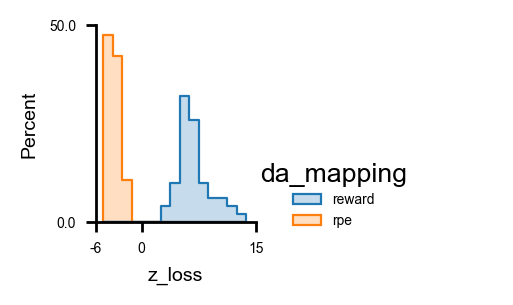

In [39]:
g = sns.displot(
    loss_df.loc[best_vals].reset_index(),
    x="z_loss",
    hue="da_mapping",
    common_norm=False,
    kind="hist",
    element="step",
    legend=True,
    bins=np.arange(-5, 15, 1.25),
    stat="percent",
)
g.fig.set_size_inches(1.05, 1.1)
l = g.legend
l.set(bbox_to_anchor=(2, 0.5))
clean_ticks(g.axes.flat[0], "y", precision=0)
clean_ticks(g.axes.flat[0], "x", precision=0, dtype=int, zero_symmetry=False)
savefig(g.fig, os.path.join(figure_cfg["store_dir"], "rl_loss_reward_v_rpe_v3"))